In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class Perceptron:
    def __init__(self, learning_rate=0.01, epochs=1000, random_state=42):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.weights = None
        self.bias = None

    def fit(self, X, Y):
        np.random.seed(self.random_state)
        self.weights = np.random.rand(X.shape[1])
        self.bias = 0
        self.epoch_accuracies = []
        for epoch in range(self.epochs):
            correct_predictions = 0
            for xi, target in zip(X.values, Y):
                linear_output = np.dot(xi, self.weights) + self.bias
                y_pred = 1 if linear_output >= 0 else -1
                if y_pred == target:
                    correct_predictions += 1
                self.weights += self.learning_rate * (target - y_pred) * xi
                self.bias += self.learning_rate * (target - y_pred)
            accuracy = correct_predictions / len(Y)
            self.epoch_accuracies.append(accuracy)

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return np.where(linear_output >= 0, 1, -1)

# Load the Fish Market Dataset, This dataset is stored on the Google Drive
data = pd.read_csv('./data/Fish.csv')
data = data[['Species', 'Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width']]

# Classes and features in the Fish Market Dataset
classes = data['Species'].unique()
features = ['Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width']

# Generate all 4C2 combinations of classes and features
class_combinations = list(combinations(classes, 2))
feature_combinations = list(combinations(features, 2))

data_subsets = []
for class_pair in class_combinations:
    for feature_pair in feature_combinations:
        subset = data[data['Species'].isin(class_pair)].copy()
        subset.loc[:, 'Label'] = subset['Species'].apply(lambda x: 1 if x == class_pair[0] else -1)
        subset = subset[list(feature_pair) + ['Label']]
        scaler = StandardScaler()
        subset.loc[:, list(feature_pair)] = scaler.fit_transform(subset[list(feature_pair)])
        data_subsets.append((class_pair, feature_pair, subset))

for i, (class_pair, feature_pair, subset) in enumerate(data_subsets):
    X = subset[list(feature_pair)]
    Y = subset['Label']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    data_subsets[i] = (class_pair, feature_pair, X_train, X_test, Y_train, Y_test)

# List to store training accuracies
training_accuracies = []
training_results = {}
testing_accuracies = []

for i, (class_pair, feature_pair, X_train, X_test, Y_train, Y_test) in enumerate(data_subsets):
    perceptron = Perceptron(learning_rate=0.001, epochs=30, random_state=42)
    perceptron.fit(X_train, Y_train)
    train_predictions = perceptron.predict(X_train)
    train_accuracy = np.mean(train_predictions == Y_train)
    training_accuracies.append(train_accuracy)
    training_results[(class_pair, feature_pair)] = {
        "model": perceptron,
        "train_accuracy": train_accuracy
    }

for (class_pair, feature_pair), result in training_results.items():
    perceptron = result["model"]
    for data in data_subsets:
        if data[0] == class_pair and data[1] == feature_pair:
            X_test = data[3]
            Y_test = data[5]
            break
    else:
        print(f"No data found for {class_pair} and {feature_pair}")
        continue

    # Predict on test set and calculate accuracy
    y_pred = perceptron.predict(X_test.values)
    test_accuracy = np.mean(y_pred == Y_test)
    testing_accuracies.append(test_accuracy)
    training_results[(class_pair, feature_pair)]["test_accuracy"] = test_accuracy

mean_training_accuracy = np.mean(training_accuracies)
mean_testing_accuracy = np.mean(testing_accuracies)

# Print mean accuracies
print(f"Mean Training Accuracy across all combinations: {mean_training_accuracy:.2f}")
print(f"Mean Testing Accuracy across all combinations: {mean_testing_accuracy:.2f}")

Mean Training Accuracy across all combinations: 0.88
Mean Testing Accuracy across all combinations: 0.85


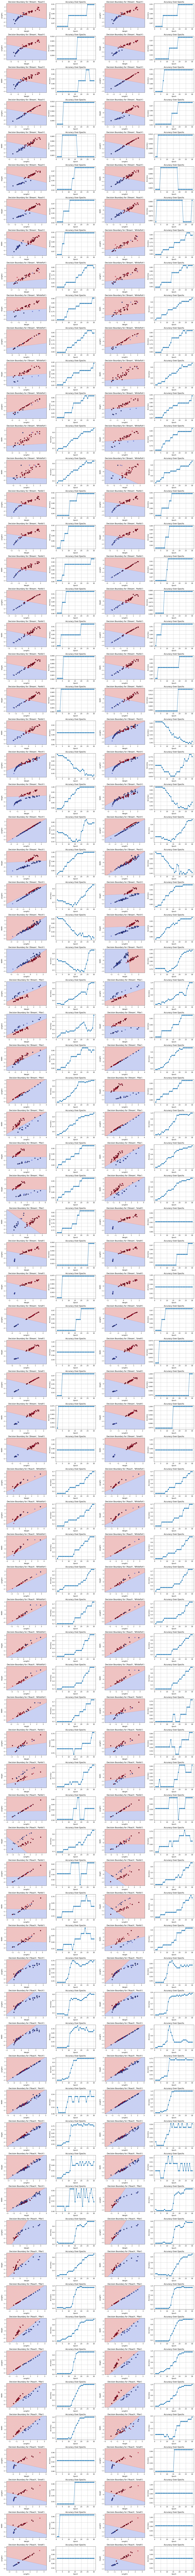

In [ ]:
num_results = len(training_results.items())
cols = 4
rows = (num_results + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 3 * rows))
plot_index = 0

axes = axes.ravel()

for (class_pair, feature_pair), result in training_results.items():
    perceptron = result["model"]
    for data in data_subsets:
        if data[0] == class_pair and data[1] == feature_pair:
            X_train = data[2]
            Y_train = data[4]
            X_test = data[3]
            Y_test = data[5]
            break
    else:
        print(f"No data found for {class_pair} and {feature_pair}")
        continue

    perceptron.fit(X_train, Y_train)
    X_combined = np.vstack([X_train, X_test])
    y_combined = np.hstack([Y_train, Y_test])
    x_min, x_max = X_combined[:, 0].min() - 1, X_combined[:, 0].max() + 1
    y_min, y_max = X_combined[:, 1].min() - 1, X_combined[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = perceptron.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    if plot_index >= axes.size:
        break

    # Plot Decision Boundary
    axes[plot_index].contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    axes[plot_index].scatter(
        X_train.iloc[:, 0],
        X_train.iloc[:, 1],
        edgecolors="k",
        cmap="coolwarm",
        c=Y_train,
        marker="o",
        label="Training Data",
    )
    axes[plot_index].scatter(
        X_test.iloc[:, 0],
        X_test.iloc[:, 1],
        cmap="coolwarm",
        c=Y_test,
        marker="x",
        label="Test Data",
    )
    axes[plot_index].set_title(f'Decision Boundary for {class_pair}')
    axes[plot_index].set_xlabel(feature_pair[0])
    axes[plot_index].set_ylabel(feature_pair[1])

    # Plot accuracy over epochs
    axes[plot_index + 1].set_title("Accuracy Over Epochs")
    axes[plot_index + 1].plot(
        range(1, len(perceptron.epoch_accuracies) + 1),
        perceptron.epoch_accuracies,
        marker="o",
    )
    axes[plot_index + 1].set_xlabel("Epoch")
    axes[plot_index + 1].set_ylabel("Accuracy")
    axes[plot_index + 1].grid()
    plot_index += 2

for i in range(plot_index, rows * cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()